In [103]:
# This file will be used to visualize transformer attention dumps
import pickle, pdb
import sys
sys.path.append('..')
import utils
from collections import defaultdict as ddict
import numpy as np
from helper import *

In [104]:
import torch_geometric

In [125]:
from torch_geometric.utils import add_remaining_self_loops

In [126]:
#data = load_pickle('./predictions/graph_test_607d1765-164c-4426-9595-7dbf01ba6150_20_05_2020_01:14:45_predictions.pkl')
data = load_pickle('../bot/predictions/basic_final_graph_seller_gat_64_08_2_001_BERT_28_06_2020_06:01:24_predictions.pkl')

In [127]:
data.keys()

dict_keys(['loss', 'metrics', 'all_preds', 'all_labels', 'all_attn_wts', 'all_extra_perm', 'all_input_graphs', 'all_extra_gat', 'all_texts', 'all_uuids'])

In [128]:
data['all_extra_gat'][0].shape

(45168, 1)

In [129]:
len(data['all_extra_gat'])

51

In [130]:
num_batches = len(data['all_preds'])
print (num_batches)

51


In [131]:
def my_batch_to_list(batch_data, attn_wts, y, gat_extra, expand_self_loops = True):
    '''
    Takes a batch data, and attention weights and returns a list of torch_geometric.Data
    '''
    #pdb.set_trace()
    edge_index = batch_data.edge_index
    batch = batch_data.batch.cpu().numpy()
    x = batch_data.x.cpu().numpy().flatten()
    y = batch_data.y.cpu().numpy()
    num_graphs = len(batch)
    if expand_self_loops:
        edge_index = add_remaining_self_loops(edge_index)[0].cpu().numpy()
    assert edge_index.shape[1] == attn_wts.shape[0], pdb.set_trace()
    assert edge_index.shape[1] == gat_extra.shape[0], pdb.set_trace()
    
    data_list = []
    curr_data = 0
    #pdb.set_trace()
    num_batches = np.max(batch) + 1
    batch_idx = 0
    while curr_data < num_batches:
        node_start = batch_idx
        curr_y = y[curr_data, :].reshape(1, -1)
        curr_x = []
        while batch_idx < len(batch) and batch[batch_idx] == curr_data:
            curr_x.append(x[batch_idx])
            batch_idx += 1
        curr_x = np.array(curr_x).reshape(-1, 1)
        node_end = batch_idx -1
        
        # take edges of datapoints in range node_start to batch_idx: edges with any number between 
        #.   node_start and node_end
        idx_to_take = np.where((edge_index[0] >= node_start) & (edge_index[0] <= node_end))[0]
        
        curr_edge_index = edge_index[:, idx_to_take]
        if len(idx_to_take) != 0:
            curr_edge_index -= np.min(curr_edge_index) # normalize it
        # Take attn_wts
        curr_attn_wts = attn_wts[idx_to_take].reshape(-1, 1)
        # Take GAT attn_wts
        curr_GAT_attn_wts = gat_extra[idx_to_take].reshape(-1, 1)
        
        data_list.append({
            'edge_index': curr_edge_index,
            'attn_wts': curr_attn_wts,
            'gat_attn_wts': curr_GAT_attn_wts,
            'x': curr_x,
            'y': curr_y
        })
        curr_data += 1
    return data_list

In [132]:
def print_custom_data_list(data_list):
    for x in data_list:
        print ('edge_index={}, x={}, y={}, attn_wts={}, gat_attn_wts={}'.format(x['edge_index'].shape, x['x'].shape, 
                                                               x['y'].shape, x['attn_wts'].shape, x['gat_attn_wts'].shape))

In [133]:
graphs_list = []
for batch in range(num_batches):
    graphs_list.append(my_batch_to_list(data['all_input_graphs'][batch], data['all_attn_wts'][batch], data['all_labels'][batch], data['all_extra_gat'][batch], True))
data['all_input_graphs_list'] = graphs_list

In [135]:
all_conv = []
for batch in range(num_batches):
    #num_conv = data['all_preds'][batch].shape[0]
    input_graphs = data['all_input_graphs_list'][batch]#.to_data_list() # List of graphs
    #print (len(input_graphs))
    start_idx = 0
    c = 0
    while start_idx < len(input_graphs):
        end_idx = start_idx + 1
        while end_idx < len(input_graphs) and input_graphs[end_idx]['x'].shape[0] >= input_graphs[end_idx-1]['x'].shape[0]:
            end_idx += 1
        #print (start_idx, end_idx)
        all_conv.append({
            'preds': data['all_preds'][batch][start_idx : end_idx],
            'labels': data['all_labels'][batch][start_idx : end_idx],
            'input_graphs': input_graphs[start_idx : end_idx]
        })
        start_idx = end_idx
        c += 1
print (len(all_conv))

561


In [134]:
all_conv_old = copy.deepcopy(all_conv)

In [183]:
data.keys()

dict_keys(['loss', 'metrics', 'all_preds', 'all_labels', 'all_attn_wts', 'all_extra_perm', 'all_input_graphs', 'all_extra_gat', 'all_texts', 'all_uuids', 'all_input_graphs_list'])

In [184]:
for i in range(len(all_conv)):
    all_conv[i]['text'] = data['all_texts'][i]
print (all_conv[0].keys())

dict_keys(['preds', 'labels', 'input_graphs', 'score', 'text'])


In [185]:
all_conv[27]['text']

['<start>',
 'hi what is your price for this cabinet ? it looks nice',
 'it is nice ! it is <price>_1.0',
 'hm . . . that seems a little expensive . especially since i can t tell much about the rest of it . would you be willing to take <price>_0.6 for it ?',
 'that may be a little bit lower than i was wanting . its all oak its got a fabulous interior . i will even throw in the delivery for free .',
 'how about <price>_0.9 in cash ?',
 'deal',
 'sounds great i look forward to having it delivered',
 '<offer>',
 '<accept>']

In [186]:
data['all_input_graphs'][0].x.shape

torch.Size([2624, 1])

In [187]:
len(data['all_extra_perm'][0])

2149

In [188]:
def get_conv_score(conv):
    '''
    Takes a conv and returns a score for it
    '''
    num_utt = int(conv['preds'].shape[0])#int(np.sum(conv['mask']))
    preds = conv['preds'][:num_utt]
    labels = conv['labels'][:num_utt]
    def sigmoid(x):
        return 1 / (1+np.exp(-x))
    preds = sigmoid(preds)
    preds[preds >= 0.5] = 1
    preds[preds < 0.5] = 0
    #pdb.set_trace()
    from sklearn.metrics import f1_score
    try:
        macro = f1_score(preds, labels, average='macro')
    except:
        return 0  # 32 conversations dont have preds
    return macro

In [189]:
tmpcntr = 0
for c in range(len(all_conv)):
    if all_conv[c]['preds'].shape[0] == 0:
        tmpcntr += 1
print (tmpcntr)
print (len(all_conv))

32
561


In [190]:
for c in range(len(all_conv)):
    score = get_conv_score(all_conv[c])
    all_conv[c]['score'] = score

/usr1/home/rjoshi2/envs/torch110/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


In [191]:
sorted_conv = sorted(all_conv, key = lambda x: x['score'], reverse = True)

In [192]:
sorted_conv[0].keys()

dict_keys(['preds', 'labels', 'input_graphs', 'score', 'text'])

In [193]:
sorted_conv[0]

{'preds': array([[ 9.9572172e+00,  8.8561273e-01,  8.6680377e-01,  3.3252484e-01,
          2.0526516e+00,  5.5901098e-01,  1.9091187e+00,  1.4087424e+00,
         -8.5233971e-03,  1.1502076e+00,  2.6580024e-01, -1.6869240e+00,
         -4.5901403e+00,  2.0098829e+00,  1.5025755e+00, -1.0109102e+00,
          2.9256537e+00,  2.8126836e-01,  1.7346761e+00,  3.7975034e-01,
          5.9602255e-01,  4.2049128e-01]], dtype=float32),
 'labels': array([[0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
         1., 0., 1., 1., 1., 0.]], dtype=float32),
 'input_graphs': [{'edge_index': array([[0],
          [0]]),
   'attn_wts': array([[1.]], dtype=float32),
   'gat_attn_wts': array([[1.]], dtype=float32),
   'x': array([[22]]),
   'y': array([[1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
           1., 0., 0., 0., 0., 0.]], dtype=float32)},
  {'edge_index': array([[1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5],
          [0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5]]),
   'attn_wts':

# Visualize scores

In [194]:
import matplotlib.pyplot as plt
%matplotlib inline

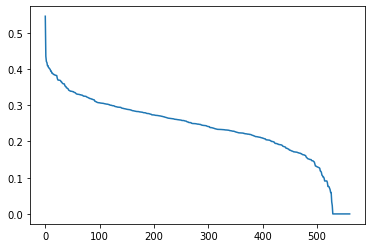

In [195]:
x = np.arange(len(sorted_conv))
y = [c['score'] for c in sorted_conv]
plt.plot(x, y)

In [196]:
# Number of conv with score > 0.45
np.sum([1 for c in sorted_conv if c['score'] > 0.35])

39

# Process data

make predictions as strategies, remove mask, make things shorter

In [197]:
temp = load_pickle('../../../data/negotiation_data/data/strategy_vector_data_FULL_Yiheng.pkl')
category2id = temp['strategies2colid']
del temp

In [198]:
#print (category2id)
id2category = {v:k for k,v in category2id.items()}
print (id2category)

{0: 'agent_id', 1: 'assertive_count', 2: 'third_person_singular', 3: 'hedge_count', 4: 'neg_sentiment', 5: 'trade_in', 6: 'liwc_informal', 7: 'personal_concern', 8: 'friend', 9: 'liwc_certainty', 10: 'first_person_singular_count', 11: 'third_person_plural', 12: 'politeness_greet', 13: 'number_of_diff_dic_neg', 14: 'factive_count', 15: 'politeness_gratitude', 16: 'number_of_diff_dic_pos', 17: 'family', 18: 'politeness_please', 19: 'pos_sentiment', 20: 'propose', 21: 'first_person_plural_count', 22: '<start>'}


In [199]:
def get_strategies_from_vec(strategies_vec):
    strats = []
    for i in range(len(strategies_vec)):
        idxes = np.where(strategies_vec[i])[0]
        strats.append([id2category[s] for s in idxes if s != 0])
    return strats

In [200]:
nodes_in_graph = []
edges_in_graph = []

In [201]:
def get_cluster_map(input_graphs):
    '''
    Takes list of input graph and augments attention map for each turn
    Also ignore node == 0 for agent
    '''
    global nodes_in_graph
    global edges_in_graph
    cluster_maps = []
    gat_attn_maps= []
    node_list = []
    turn_list = []
    for turn, graph in enumerate(input_graphs):
        nodes_in_graph.append(graph['x'].shape[0])
        edges_in_graph.append(graph['edge_index'].shape[1])
        num_nodes = graph['x'].shape[0] - np.sum(graph['x'] == 0) # ignore 0
        num_full_nodes = graph['x'].shape[0]
        
        node_list.append([xval for xval in graph['x'].flatten() if xval != 0])
        agent_idxes = [i for i,xval in enumerate(graph['x'].flatten()) if xval == 0]
        turn_arr = np.zeros(num_nodes, dtype=np.int32)
        curr_turn_start = 0
        if turn != 0:
            turn_arr[:len(turn_list[-1])] = turn_list[-1] # copy from prev
            curr_turn_start = len(turn_list[-1])
        turn_arr[curr_turn_start : ] = turn # fill current turn
        turn_list.append(turn_arr)
        
        cluster_map = np.zeros((num_full_nodes, num_full_nodes))
        gat_attn_map = np.zeros((num_full_nodes, num_full_nodes))
        for i in range(graph['edge_index'].shape[1]): # num edges
            start_node = graph['edge_index'][0][i]
            end_node   = graph['edge_index'][1][i]
            cluster_map[start_node][end_node] = graph['attn_wts'][i][0]
            gat_attn_map[start_node][end_node] = graph['gat_attn_wts'][i][0]
        
        # clean cluster map remove rows and cols with idx in agent_idxes
        cluster_map = np.delete(cluster_map, agent_idxes, axis = 0) # rows
        cluster_map = np.delete(cluster_map, agent_idxes, axis = 1) # cols
        # clean gat_attn_map remove rows and cols with idx in agent_idxes
        gat_attn_map = np.delete(gat_attn_map, agent_idxes, axis = 0) # rows
        gat_attn_map = np.delete(gat_attn_map, agent_idxes, axis = 1) # cols
        assert cluster_map.shape[0] == num_nodes
        assert gat_attn_map.shape[0] == num_nodes
        cluster_maps.append(cluster_map)
        gat_attn_maps.append(gat_attn_map)
        
    return cluster_maps, gat_attn_maps, node_list, turn_list

In [202]:
sorted_conv[0].keys()

dict_keys(['preds', 'labels', 'input_graphs', 'score', 'text'])

In [203]:
final_conv = []
for c in range(len(sorted_conv)):
    num_utt = sorted_conv[c]['preds'].shape[0]#int(np.sum(sorted_conv[c]['mask']))
    preds = sorted_conv[c]['preds'][:num_utt]
    labels = sorted_conv[c]['labels'][:num_utt]
    text = sorted_conv[c]['text'][:num_utt]
    pred_strat = get_strategies_from_vec(preds)
    true_strat = get_strategies_from_vec(labels)
    #attn = sorted_conv[c]['attn'][:, :, :num_utt, :num_utt]
    cluster_maps, gat_attn_maps, node_list, turn_list = get_cluster_map(sorted_conv[c]['input_graphs'])
    strat_list = [[id2category[s] for s in nl] for nl in node_list]
    final_conv.append({
        'preds': pred_strat,
        'labels': true_strat,
        #'input_graphs': sorted_conv[c]['input_graphs'],
        'cluster_maps': cluster_maps,
        'gat_attn_maps': gat_attn_maps,
        'node_list': node_list,
        'strat_list': strat_list,
        'turn_list': turn_list,
        'score': sorted_conv[c]['score'],
        'text': text
    })

# Visualize Attention Maps of the 6 decoders 2 heads each

In [204]:
final_conv[0]

{'preds': [['assertive_count',
   'third_person_singular',
   'hedge_count',
   'neg_sentiment',
   'trade_in',
   'liwc_informal',
   'personal_concern',
   'friend',
   'liwc_certainty',
   'first_person_singular_count',
   'third_person_plural',
   'politeness_greet',
   'number_of_diff_dic_neg',
   'factive_count',
   'politeness_gratitude',
   'number_of_diff_dic_pos',
   'family',
   'politeness_please',
   'pos_sentiment',
   'propose',
   'first_person_plural_count']],
 'labels': [['assertive_count',
   'third_person_singular',
   'hedge_count',
   'neg_sentiment',
   'personal_concern',
   'first_person_singular_count',
   'number_of_diff_dic_neg',
   'factive_count',
   'number_of_diff_dic_pos',
   'politeness_please',
   'pos_sentiment',
   'propose']],
 'cluster_maps': [array([[1.]]),
  array([[9.99999940e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00],
         [2.20814977e-10, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000

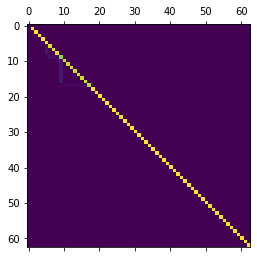

In [205]:
plt.matshow(final_conv[0]['cluster_maps'][-1])#[0][4:5][:])

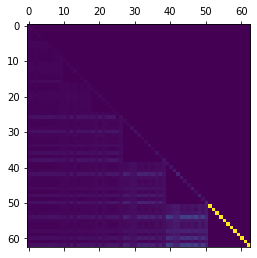

In [206]:
plt.matshow(final_conv[0]['gat_attn_maps'][-1])#[0][4:5][:])

In [207]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def plot_heatmap(turn_list, node_list, scores, rowwise_norm = False, remove_diag = False, start_turn = -1):
    '''
    turn list is list of turns
    node list is list of nodes
    scoores is matrix of attention scores
    start turn says if you have to start printing from a specific turn. That turn will be in src (top).
    The rows will start from start_turn + 1 (tgt)
    
    turn first is first place where start_turn is there. and turn_second is first turn where start_turn+1 is there (for tgt)
    tgt is row!!
    src is col!!
    
    last tgt turn is last turn for removing columns end 
    turn end col is the turn numebr in turn list corresponding to that
    '''
    last_tgt_turn = sorted(list(set(turn_list)))[-2] # this is for target (columns)
    turn_end_col = 0
    while turn_list[turn_end_col] != last_tgt_turn:
        turn_end_col += 1
    if start_turn == -1:
        turn_first = 0
        turn_second = 0
    else:
        turn_first = 0
        turn_second = 0
        while turn_list[turn_first] < start_turn:
            turn_first += 1
        turn_second = turn_first
        while turn_list[turn_second] < start_turn + 1:
            turn_second += 1
    print (turn_first)
    print (turn_second)
    print (last_tgt_turn)
    print (turn_end_col)
    fig, ax = plt.subplots(figsize=(16,16))
    scores2 = copy.deepcopy(scores)#.copy()
    #pdb.set_trace()
    if rowwise_norm:
        for i in range(len(scores2)):
            if remove_diag:
                scores2[i,i] = 0
            scores2[i, :] /= np.max(scores2[i, :])
    if False:
        heatmap = ax.pcolor(scores2, cmap='viridis')
    else:
        heatmap = ax.pcolor(scores2[turn_second:, turn_first:turn_end_col], cmap='viridis')
    
    if False:
        src = [str(turn_list[i]) + '_' + str(node_list[i]) for i in range(len(turn_list))]
        trg = [str(turn_list[i]) + '_' + str(node_list[i]) for i in range(len(turn_list))]
        trg = src
    else:
        src = [str(turn_list[i]) + '_' + str(node_list[i]) for i in range(len(turn_list))]
        trg = src[turn_first:turn_end_col]
        src = src[turn_second:]
        
    ax.set_xticklabels(trg, minor=False, rotation='vertical')
    ax.set_yticklabels(src, minor=False)

    # put the major ticks at the middle of each cell
    # and the x-ticks on top
    ax.xaxis.tick_top()
    if False:
        ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
        ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    else:
        ax.set_xticks(np.arange(scores[turn_second:, turn_first:turn_end_col].shape[1]) + 0.5, minor=False)
        ax.set_yticks(np.arange(scores[turn_second:, turn_first:turn_end_col].shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)
    plt.show()

In [276]:
def plot_heatmap(turn_list, node_list, scores, rowwise_norm = False, remove_diag = False, start_turn = 0):
    '''
    turn list is list of turns
    node list is list of nodes
    scoores is matrix of attention scores
    start turn says if you have to start printing from a specific turn. That turn will be in src (top).
    The rows will start from start_turn + 1 (tgt)
    
    turn first is first place where start_turn is there. and turn_second is first turn where start_turn+1 is there (for tgt)
    tgt is row!!
    src is col!!
    
    last tgt turn is last turn for removing columns end 
    turn end col is the turn numebr in turn list corresponding to that
    '''
    last_src_turn = sorted(list(set(turn_list)))[-1] # this is for removing last src (columns)
    turn_end_col = 0
    while turn_list[turn_end_col] != last_src_turn:
        turn_end_col += 1
    if start_turn == 0:
        turn_first = 0
        turn_second = 1
    else:
        turn_first = 0
        turn_second = 1
        while turn_list[turn_first] < start_turn:
            turn_first += 1
        turn_second = turn_first
        while turn_list[turn_second] < start_turn + 1:
            turn_second += 1
    print (turn_first)
    print (turn_second)
    print (last_src_turn)
    print (turn_end_col)
    fig, ax = plt.subplots(figsize=(16,16))
    scores2 = copy.deepcopy(scores)#.copy()
    #pdb.set_trace()
    if rowwise_norm:
        for i in range(len(scores2)):
            if remove_diag:
                scores2[i,i] = 0
            #scores2[i, :] /= np.max(scores2[i, :])
            scores2[i, :] /= np.sum(scores2[i, :])
    heatmap = ax.pcolor(scores2[turn_second:, turn_first:turn_end_col], cmap='viridis')
    
    src = [str(turn_list[i]) + '_' + str(node_list[i]) for i in range(len(turn_list))]
    trg = src[turn_second:]            #row
    src = src[turn_first:turn_end_col] #col
        
    ax.set_xticklabels(src, minor=False, rotation=90, fontsize=18) #rotation='vertical'
    ax.set_yticklabels(trg, minor=False, fontsize=18)

    # put the major ticks at the middle of each cell
    # and the x-ticks on top
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores[turn_second:, turn_first:turn_end_col].shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores[turn_second:, turn_first:turn_end_col].shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)
    #plt.show()
    plt.tight_layout()
    plt.savefig('../AttentionMapFigure.pdf', pad_inches = 10)

In [277]:
print(len(final_conv))

561


27
0
1
7
21


/usr1/home/rjoshi2/envs/torch110/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


4
9
7
21


/usr1/home/rjoshi2/envs/torch110/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


<start>
hey you need a router ?
yeah i was looking at the apple router and had a few questions for you .
oh okay it supports multiple devices and is from the latest generation for apple devices what s up ?
will it support a apple laptop ?
oh definitely both with wifi and cabled capabilities . i ll throw in the cables if you want <price>_-0.7 and we re square ?
sounds like a good deal how much has it been used ? is there any scratches or damage to it ?


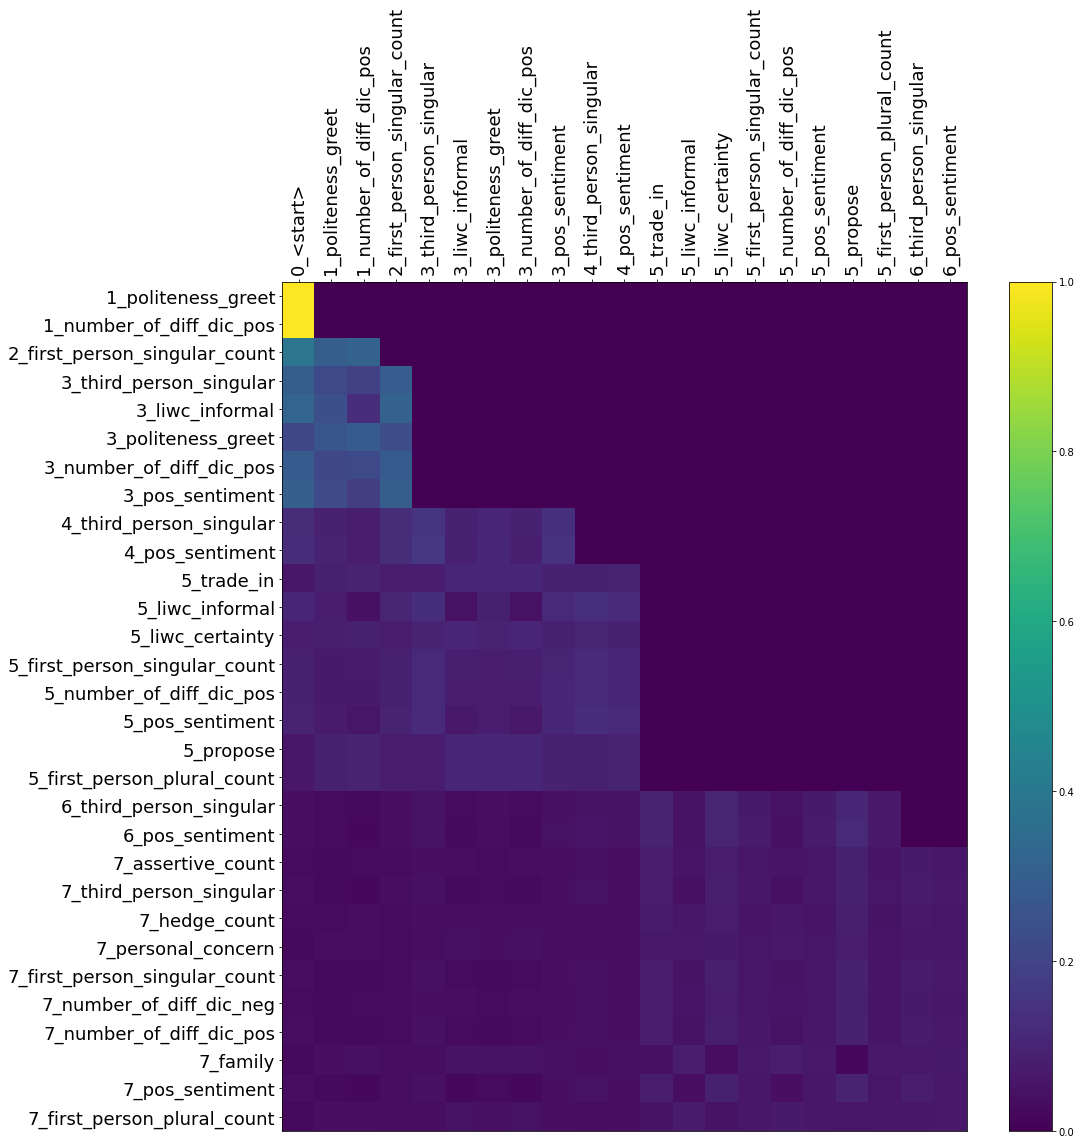

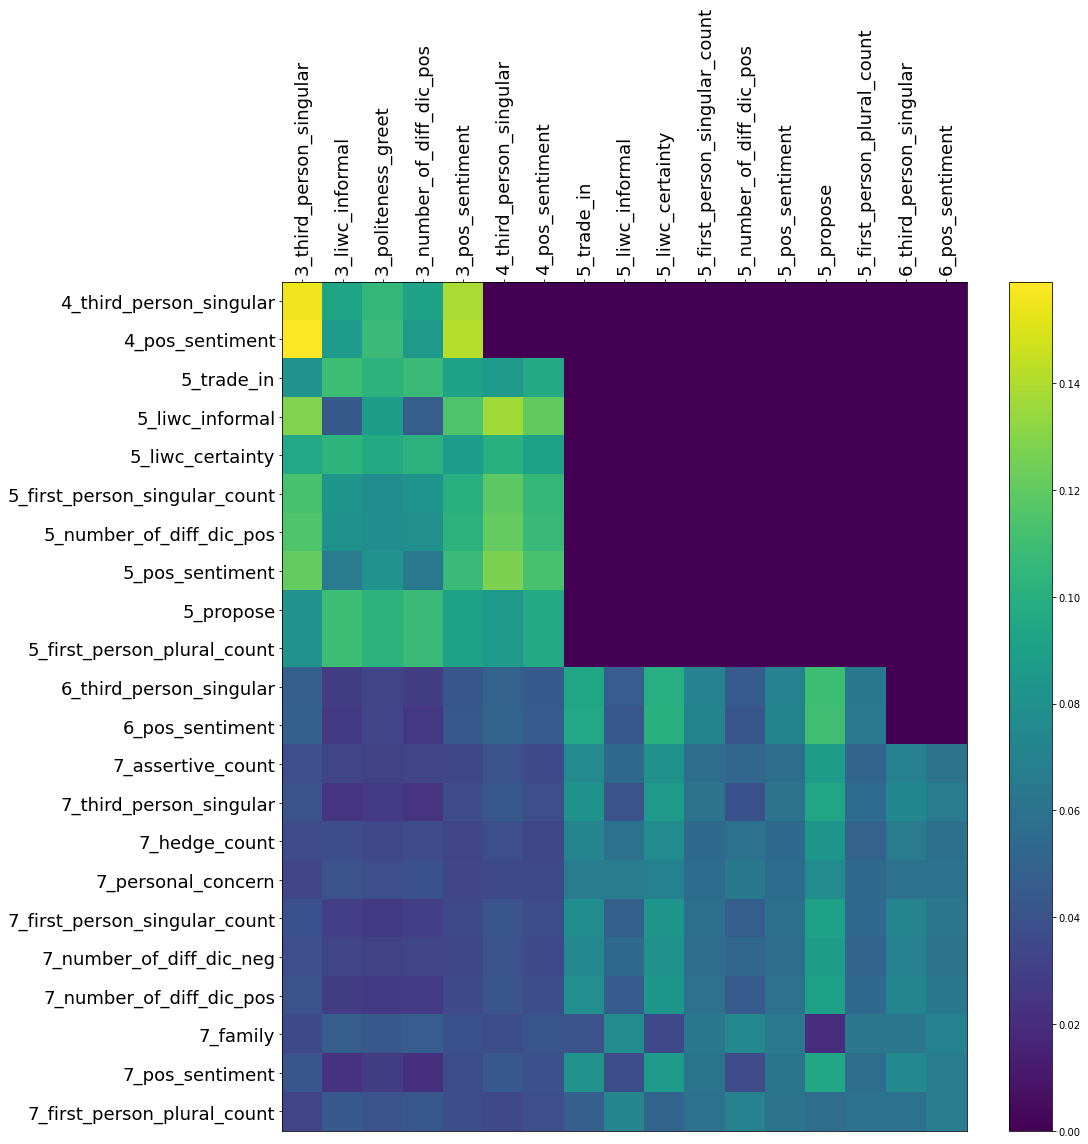

In [278]:
# src = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
# trg = src
# scores = final_conv[0]['attn'][0][0]
#for cn in range(len(final_conv)):#chosen_ids
#for cn in [105, 107, 134, 228, 268]:
###for cn in [5,14,26,27,29,33,34]:
for cn in [27]:
#    turn_number = 6
#     flag = 1
# #     for x in range(turn_number + 1):
# #         if np.sum(final_conv[cn]['turn_list'][-1] == x) > 3:
# #             flag = 0
#     flag = 0
#     scores = copy.deepcopy(final_conv[cn]['cluster_maps'][-1])
#     for i in range(len(scores)):
#         check = 0
#         scores[i,i] = 0
#         scores[i,:] /= np.max(scores[i,:])
#         turns = set()
#         for j in range(i):
#             if scores[i,j] > 1e-1:
#                 check += 1
#                 turns.add(final_conv[cn]['turn_list'][-1][j])
#         if len(turns) > 3:
#             flag = 1
#             print ('check at ', i)
#             #pdb.set_trace()
#             turn_number = max(list(turns))
#             break
#     if flag == 0:
#         continue
    print(cn)
    conv_number = cn
    turn_number = min(7, final_conv[conv_number]['turn_list'][-1][-1])
#     plot_heatmap(final_conv[conv_number]['turn_list'][turn_number], 
#                  final_conv[conv_number]['strat_list'][turn_number], 
#                  final_conv[conv_number]['cluster_maps'][turn_number], 
#                  rowwise_norm = True,
#                  remove_diag = True)
    plot_heatmap(final_conv[conv_number]['turn_list'][turn_number], 
                 final_conv[conv_number]['strat_list'][turn_number], 
                 final_conv[conv_number]['gat_attn_maps'][turn_number], 
                 rowwise_norm = True,
                 remove_diag = True)
    plot_heatmap(final_conv[conv_number]['turn_list'][turn_number], 
                 final_conv[conv_number]['strat_list'][turn_number], 
                 final_conv[conv_number]['gat_attn_maps'][turn_number], 
                 rowwise_norm = True,
                 remove_diag = True,
                start_turn = 3)
    #pdb.set_trace()
    #plt.clf()
    print ('\n'.join(final_conv[conv_number]['text'][:turn_number]))

In [272]:
scores2 = copy.deepcopy(final_conv[27]['gat_attn_maps'][8])#.copy()
for i in range(len(scores2)):
    if True:
        scores2[i,i] = 0
    scores2[i, :] /= np.sum(scores2[i, :])
#print (scores2[1:])
import pickle
pickle.dump(scores2, open('gat_scores.pkl', 'wb'))

/usr1/home/rjoshi2/envs/torch110/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [280]:
temp = copy.deepcopy(final_conv[27]['gat_attn_maps'][8])
print (temp[11])
print (scores2[11])
print (src[11])

[0.03368774 0.0461337  0.04862166 0.04164818 0.04238432 0.05437464
 0.05140654 0.05383584 0.04682623 0.0442849  0.04865501 0.05511105
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.06581453 0.09012974 0.09499039 0.08136654 0.08280471 0.10622977
 0.1004311  0.10517714 0.09148272 0.08651781 0.09505554 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
5_trade_in


In [255]:
turn_number = min(8, final_conv[27]['turn_list'][-1][-1])
turn_list = final_conv[27]['turn_list'][turn_number]
node_list = final_conv[27]['strat_list'][turn_number]

src = [str(turn_list[i]) + '_' + str(node_list[i]) for i in range(len(turn_list))]
print (src)

['0_<start>', '1_politeness_greet', '1_number_of_diff_dic_pos', '2_first_person_singular_count', '3_third_person_singular', '3_liwc_informal', '3_politeness_greet', '3_number_of_diff_dic_pos', '3_pos_sentiment', '4_third_person_singular', '4_pos_sentiment', '5_trade_in', '5_liwc_informal', '5_liwc_certainty', '5_first_person_singular_count', '5_number_of_diff_dic_pos', '5_pos_sentiment', '5_propose', '5_first_person_plural_count', '6_third_person_singular', '6_pos_sentiment', '7_assertive_count', '7_third_person_singular', '7_hedge_count', '7_personal_concern', '7_first_person_singular_count', '7_number_of_diff_dic_neg', '7_number_of_diff_dic_pos', '7_family', '7_pos_sentiment', '7_first_person_plural_count', '8_third_person_plural', '8_pos_sentiment', '8_propose']


In [260]:
mappings = ddict(lambda: ddict(float)) # dest is first
for i in range(1, len(scores2)):
    for j in range(len(scores2[i])):
        if scores2[i][j] != 0:
            mappings[src[i]][src[j]] = scores2[i][j]
for k in mappings:
    mappings[k] = dict(mappings[k])
mappings = dict(mappings)
print (mappings)

{'1_politeness_greet': {'0_<start>': 1.0}, '1_number_of_diff_dic_pos': {'0_<start>': 1.0}, '2_first_person_singular_count': {'0_<start>': 1.0, '1_politeness_greet': 0.7284423339295194, '1_number_of_diff_dic_pos': 0.7677268436116457}, '3_third_person_singular': {'0_<start>': 1.0, '1_politeness_greet': 0.7146956594257212, '1_number_of_diff_dic_pos': 0.6197496524828654, '2_first_person_singular_count': 0.9533340224058086}, '3_liwc_informal': {'0_<start>': 1.0, '1_politeness_greet': 0.714695531175243, '1_number_of_diff_dic_pos': 0.3815856267498643, '2_first_person_singular_count': 0.9533342166021813}, '3_politeness_greet': {'0_<start>': 0.7992247229153787, '1_politeness_greet': 0.948830094901339, '1_number_of_diff_dic_pos': 1.0, '2_first_person_singular_count': 0.8565765281617146}, '3_number_of_diff_dic_pos': {'0_<start>': 1.0, '1_politeness_greet': 0.7146955655152074, '1_number_of_diff_dic_pos': 0.7302097498681297, '2_first_person_singular_count': 0.9533342349252419}, '3_pos_sentiment': {

In [121]:
mappings['6_third_person_singular']

{'0_<start>': 0.36964535956082245,
 '1_politeness_greet': 0.2641839340049798,
 '1_number_of_diff_dic_pos': 0.22908758312972355,
 '2_first_person_singular_count': 0.3523955359312516,
 '3_third_person_singular': 0.44786035013633396,
 '3_liwc_informal': 0.2561935675165683,
 '3_politeness_greet': 0.2943787936362582,
 '3_number_of_diff_dic_pos': 0.2536548480861935,
 '3_pos_sentiment': 0.39223564980462605,
 '4_third_person_singular': 0.4679430168802856,
 '4_pos_sentiment': 0.40755422011752185,
 '5_trade_in': 0.8463947900901689,
 '5_liwc_informal': 0.37067052589330074,
 '5_liwc_certainty': 0.9178270240625614,
 '5_first_person_singular_count': 0.5795744093329919,
 '5_number_of_diff_dic_pos': 0.3655562639158133,
 '5_pos_sentiment': 0.5770357667775998,
 '5_propose': 1.0,
 '5_first_person_plural_count': 0.5338773058362795}

In [261]:
mappings['6_third_person_singular']

{'0_<start>': 0.36964541639379245,
 '1_politeness_greet': 0.26418397462325677,
 '1_number_of_diff_dic_pos': 0.22908761835193694,
 '2_first_person_singular_count': 0.35239555167456416,
 '3_third_person_singular': 0.44786034211986336,
 '3_liwc_informal': 0.25619360690632653,
 '3_politeness_greet': 0.2943788388969945,
 '3_number_of_diff_dic_pos': 0.2536549255231209,
 '3_pos_sentiment': 0.3922356716733557,
 '4_third_person_singular': 0.46794312726401666,
 '4_pos_sentiment': 0.40755428277897876,
 '5_trade_in': 0.8463949970983533,
 '5_liwc_informal': 0.3706705444463928,
 '5_liwc_certainty': 0.9178271651784564,
 '5_first_person_singular_count': 0.5795745368800483,
 '5_number_of_diff_dic_pos': 0.3655563201200849,
 '5_pos_sentiment': 0.5770359323718373,
 '5_propose': 1.0,
 '5_first_person_plural_count': 0.5338773879199095}

In [123]:
final_conv[27].keys()

dict_keys(['preds', 'labels', 'cluster_maps', 'gat_attn_maps', 'node_list', 'strat_list', 'turn_list', 'score'])

In [101]:
len(scores2)

34

In [158]:
scores2 = copy.deepcopy(final_conv[1]['cluster_maps'][3])#.copy()
for i in range(len(scores2)):
    if True:
        scores2[i,i] = 0
    scores2[i, :] /= np.max(scores2[i, :])
print (scores2[1:])

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [5.73746082e-06 1.00000000e+00 9.13809802e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [5.73746081e-06 1.00000000e+00 9.13809896e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [5.73746085e-06 1.00000000e+00 9.13809898e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+0

/usr1/home/rjoshi2/envs/torch110/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [65]:
from collections import defaultdict as ddict
associations = ddict(lambda : ddict(list))
for cn in range(len(final_conv)):
    clus = final_conv[cn]['cluster_maps'][-1]
    scores2 = copy.deepcopy(clus)#.copy()
    if True:
        for i in range(len(scores2)):
            if True:
                scores2[i,i] = 0
            scores2[i, :] /= np.max(scores2[i, :])
    stlist = final_conv[cn]['strat_list'][-1]
    tlist = final_conv[cn]['turn_list'][-1]
    for i in range(len(scores2)):
        for j in range(len(scores2)):
            if scores2[i][j] > 1e-5:
                associations[stlist[i]][stlist[j]].append(scores2[i][j])

/usr1/home/rjoshi2/envs/torch110/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [71]:
for k,val in associations.items():
    print (k)
    sorted_val = sorted(val.items(), key = lambda x : np.mean(x[1]))
    for k2,lis in sorted_val:
        print ('{}\t{:.4}'.format(k2, np.mean(lis)))
    print()

personal_concern
family	0.07407
liwc_certainty	0.1759
number_of_diff_dic_pos	0.2229
trade_in	0.228
number_of_diff_dic_neg	0.2302
liwc_informal	0.2712
personal_concern	0.2999
friend	0.322
neg_sentiment	0.3232
first_person_plural_count	0.3379
third_person_singular	0.4572
third_person_plural	0.4582
pos_sentiment	0.4799
factive_count	0.4994
first_person_singular_count	0.5085
assertive_count	0.5196
hedge_count	0.5412
politeness_greet	0.5659
propose	0.5827
politeness_gratitude	0.5859
politeness_please	0.7072
<start>	0.987

first_person_singular_count
trade_in	0.3485
family	0.376
neg_sentiment	0.3869
first_person_plural_count	0.3916
liwc_certainty	0.4178
third_person_singular	0.4289
pos_sentiment	0.4363
hedge_count	0.4366
number_of_diff_dic_neg	0.4366
first_person_singular_count	0.4491
personal_concern	0.4492
third_person_plural	0.4497
factive_count	0.4503
number_of_diff_dic_pos	0.4506
propose	0.4604
liwc_informal	0.4642
friend	0.4655
assertive_count	0.4685
politeness_please	0.5566
politeness

In [68]:
from collections import defaultdict as ddict
dependence = ddict(lambda : ddict(list))
for cn in range(len(final_conv)):
    clus = final_conv[cn]['gat_attn_maps'][-1]
    scores2 = copy.deepcopy(clus)#.copy()
    if True:
        for i in range(len(scores2)):
            if True:
                scores2[i,i] = 0
            scores2[i, :] /= np.max(scores2[i, :])
    stlist = final_conv[cn]['strat_list'][-1]
    tlist = final_conv[cn]['turn_list'][-1]
    for i in range(len(scores2)):
        for j in range(len(scores2)):
            if scores2[i][j] > 1e-5:
                dependence[stlist[i]][stlist[j]].append(scores2[i][j])

/usr1/home/rjoshi2/envs/torch110/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [72]:
for k,val in dependence.items():
    print (k)
    sorted_val = sorted(val.items(), key = lambda x : np.mean(x[1]))
    for k2,lis in sorted_val:
        print ('{}\t{:.4}'.format(k2, np.mean(lis)))
    print()

personal_concern
<start>	0.5385
third_person_singular	0.5531
factive_count	0.5593
third_person_plural	0.5646
trade_in	0.5726
pos_sentiment	0.5879
first_person_plural_count	0.5906
first_person_singular_count	0.5958
liwc_certainty	0.6052
politeness_gratitude	0.6361
assertive_count	0.6475
number_of_diff_dic_neg	0.6511
politeness_greet	0.654
propose	0.6589
hedge_count	0.6631
politeness_please	0.6631
neg_sentiment	0.6641
family	0.6673
personal_concern	0.6725
liwc_informal	0.684
number_of_diff_dic_pos	0.6944
friend	0.7362

first_person_singular_count
politeness_greet	0.4109
third_person_plural	0.4392
personal_concern	0.4521
number_of_diff_dic_pos	0.48
number_of_diff_dic_neg	0.4802
first_person_plural_count	0.4966
liwc_informal	0.502
assertive_count	0.5274
pos_sentiment	0.534
politeness_gratitude	0.5375
<start>	0.5433
first_person_singular_count	0.5458
factive_count	0.5606
third_person_singular	0.5635
family	0.6196
hedge_count	0.6343
liwc_certainty	0.6365
neg_sentiment	0.6369
propose	0.652
fr

In [73]:
# ANALYSIS # of nodes / edges

In [84]:
print (np.max(nodes_in_graph))
print (np.mean(nodes_in_graph))
print (np.max(edges_in_graph))
print (np.mean(edges_in_graph))

86
21.12098207074786
3589
308.1200129219835


# Plot

In [327]:
#chosen_ids = [6, 7, 18, 21, 22, 32, 33, 70, 94, 113, 117, 119, 228]
chosen_ids = [6,113, 117]

In [307]:
import networkx as nx

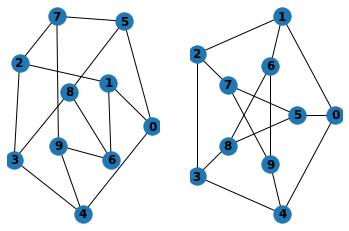

In [308]:
G = nx.petersen_graph()
plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')
plt.subplot(122)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels = True, font_weight='bold')

In [311]:
nlist = [range(5, 10), range(5)]

In [313]:
print (list(nlist[0]))
print (list(nlist[1]))

[5, 6, 7, 8, 9]
[0, 1, 2, 3, 4]


In [316]:
G = nx.path_graph(4)
pos = nx.drawing.layout.kamada_kawai_layout(G)

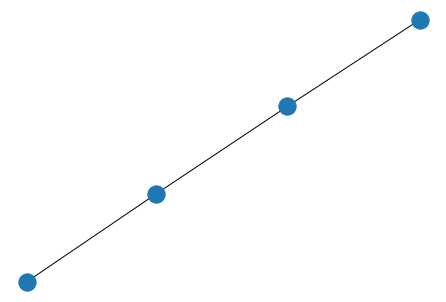

In [319]:
nx.draw_kamada_kawai(G)

In [320]:
pos

{0: array([0.99996577, 0.99366857]),
 1: array([0.32913544, 0.33543827]),
 2: array([-0.33544334, -0.32910684]),
 3: array([-0.99365787, -1.        ])}

5


/usr1/home/rjoshi2/envs/torch110/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


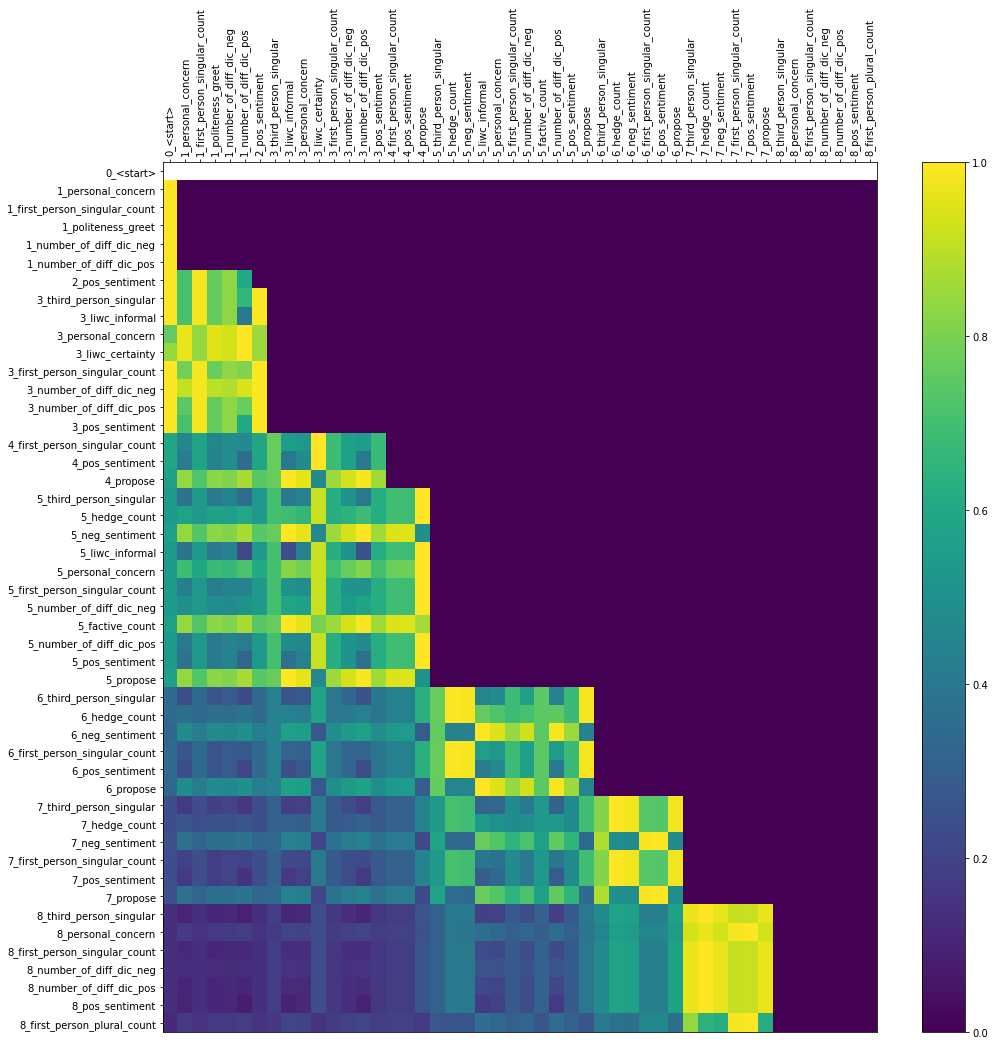

<start>
hello i received your e mail regarding this apartment .
the apartment sounds and looks great
oh it s wonderful ! it s a 5 br 2 bath large apartment located right near berkeley . perfect for university students . all amenities are there in the ad and i am asking <price>_1.0 for a 1 year lease .
great . can i offer you 7 <price>_-1.1
oh i see i did not set it as serious inquiries only . this is a great apartment in a nice and immaculate area . i m sorry but for a 1 year lease i will not be able to go that price . but for the right tennant i might be able to go at <price>_0.5 for 1 year .
i wouldn t like to miss the opportunity . lets cap it at 8 <price>_-0.0
<offer>
14


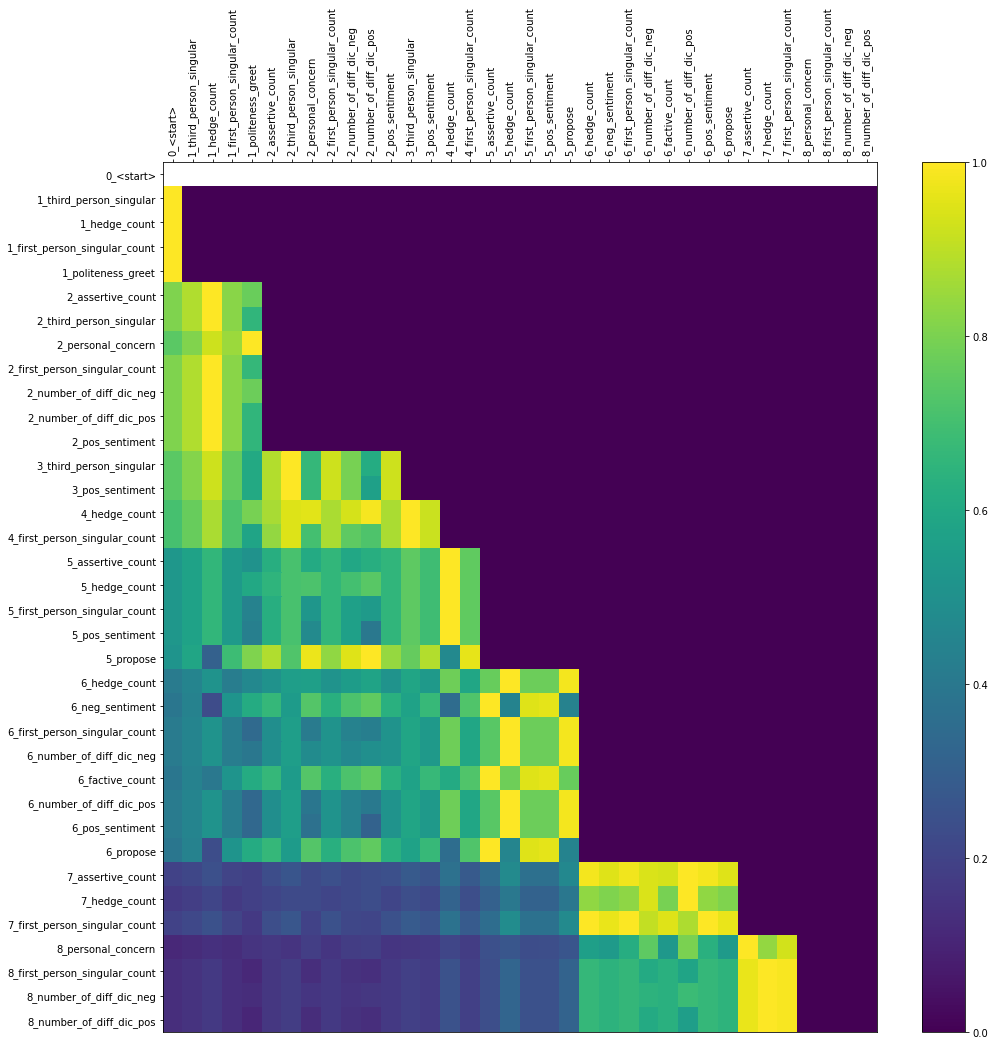

<start>
hello i m interested in your civic can you tell me more about it ?
good little car great gas mileage . only k original miles . i used it to commute to back and forth to work . no issues that i can think of just a nice little car that is cheap to drive .
what kind of gas mileage does it get ?
i am averaging around city highway .
that s good but i m not so sure i want to pay so much for such an old car . how about <price>_0.0 ?
i couldn t come down nearly that low . car is in great shape and only <price>_0.7 k miles . this car is good for at least another <price>_0.7 k miles perhaps more with really good care . i could come down to <price>_0.7 if that helps you .
i suppose i could stretch that much in a month or two but right now the most i can do is <price>_0.5 .
26


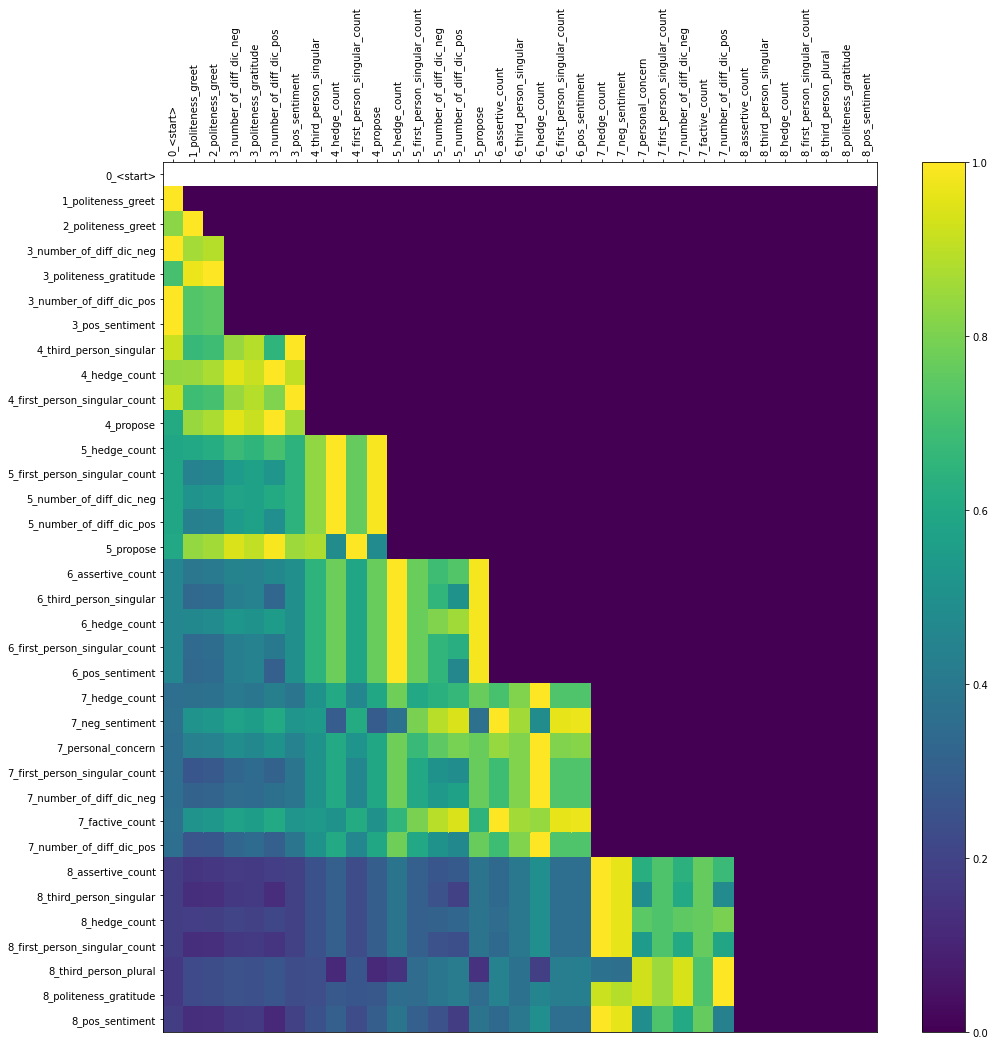

<start>
hello !
hi . how are you ?
good thanks . so you are interested in flashing your phone ?
i am . the only way i will be able to use this phone is to have it flashed however all i have is <price>_-0.1 and i have to buy diapers also this evening . the diapers are <price>_-0.1 . <price>_-0.1 and all i have is the remainder . is there a way you could work with me somehow ?
i could come down a little . can you do <price>_0.6 ?
i believe the service is valued at more than i have but if i do <price>_0.6 i would not be able to afford my sons diapers as well . i believe your service is worth more and if i had it to offer i most definitely would
i am sorry to hear about your predicament . could you buy a smaller pack of diapers and pay <price>_0.2 ?
27


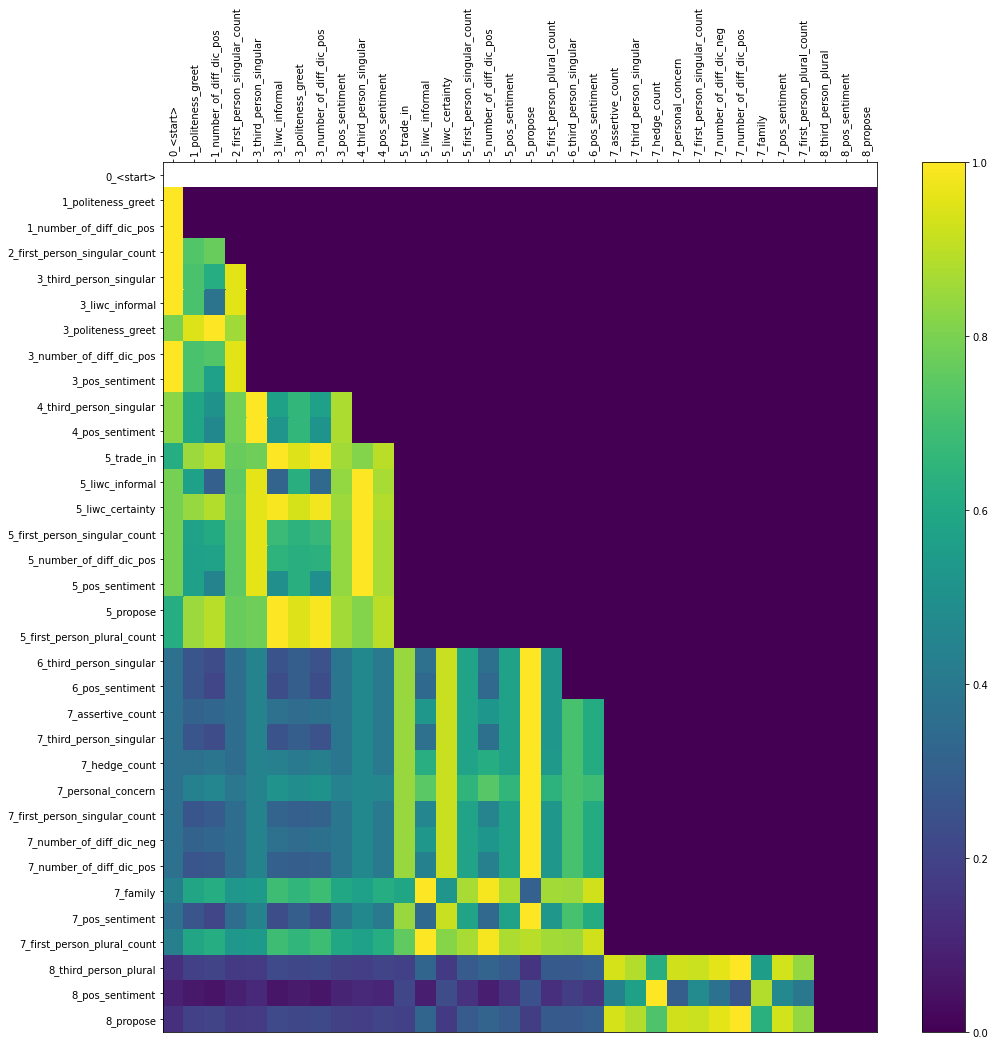

<start>
hey you need a router ?
yeah i was looking at the apple router and had a few questions for you .
oh okay it supports multiple devices and is from the latest generation for apple devices what s up ?
will it support a apple laptop ?
oh definitely both with wifi and cabled capabilities . i ll throw in the cables if you want <price>_-0.7 and we re square ?
sounds like a good deal how much has it been used ? is there any scratches or damage to it ?
nah it s only seen about a few months use we re moving and the wife wants me to go pc so happy wife happy life i suppose
29


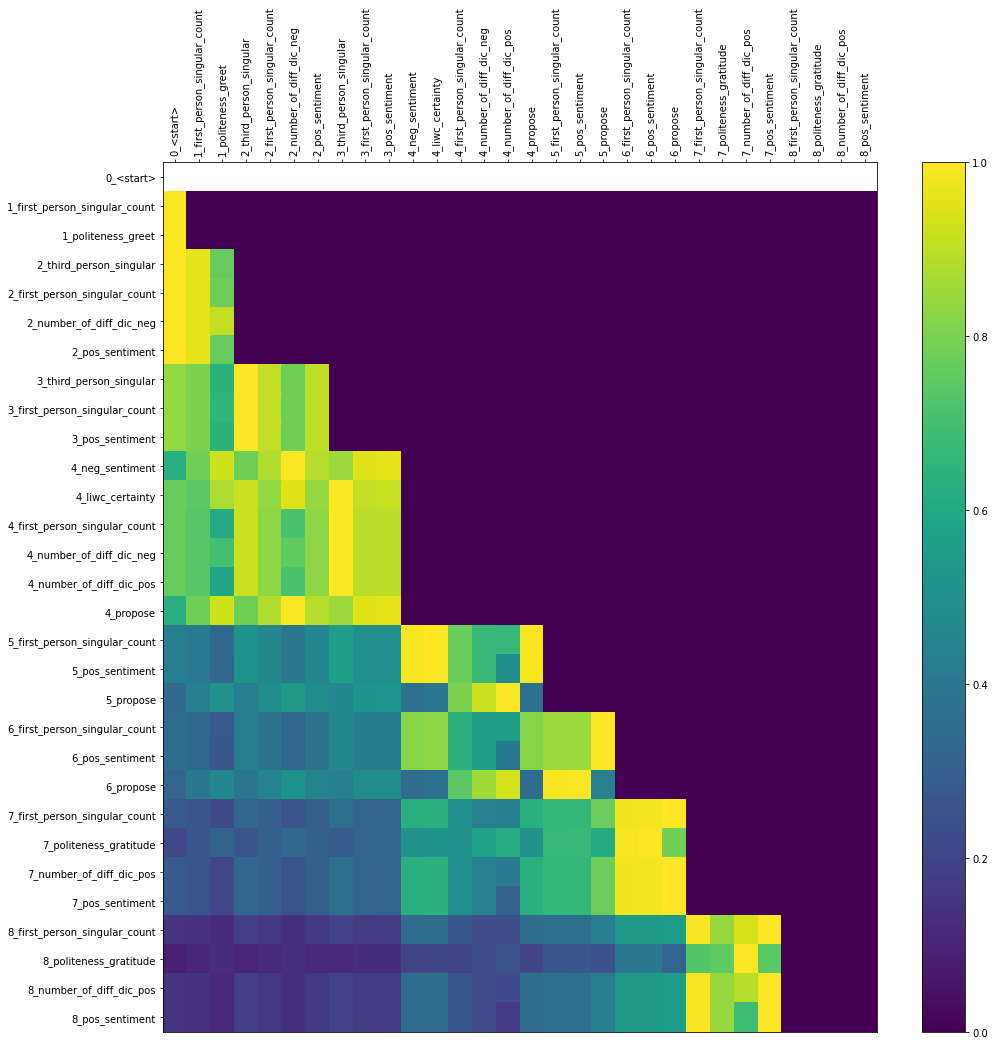

<start>
hi ! i am interested in the house !
great ! i m asking <price>_1.0 for it . it s in great condition and very centrally located .
is a little high for me . has it been updated to modern appliances ?
yes all appliances were replaced within the last 2 years . i have a few other people interested so i m willing to go as low as <price>_-1.0 but that s as low as i can go .
wow <price>_-1.0 is a really good deal . i
<offer>
thank you . i m glad you accept the offer .
33


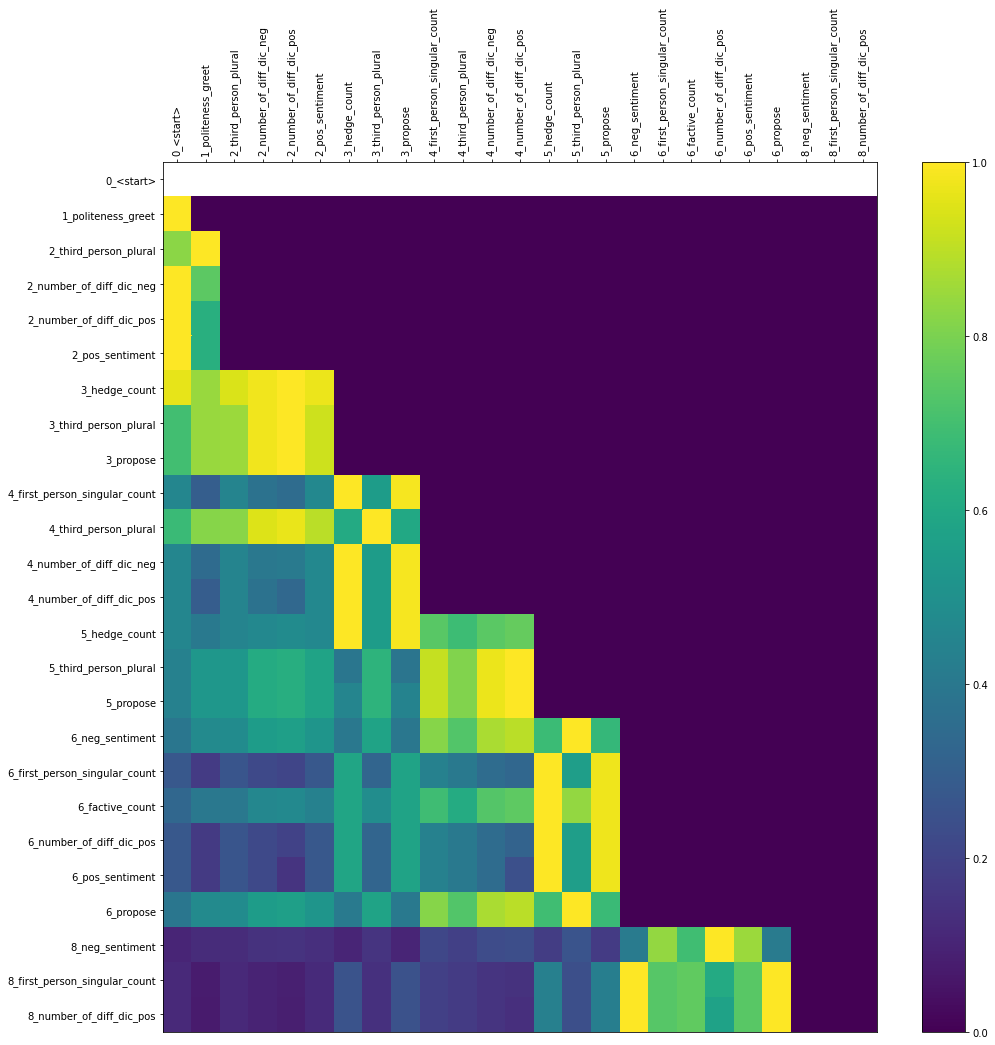

<start>
hi . how old are your chairs ?
they are just a few years old . they are in great condition .
ok . would you be willing to take <price>_-0.5 for all of them ?
i can take <price>_-0.5 each if you take more than 4 . they are quality wood chairs .
ok . what about taking 8 of them for <price>_0.0 and you deliver them tomorrow ?
are you offering me for chairs ? sorry i cannot accept such a low offer .
how much are you wanting per chair ?
34


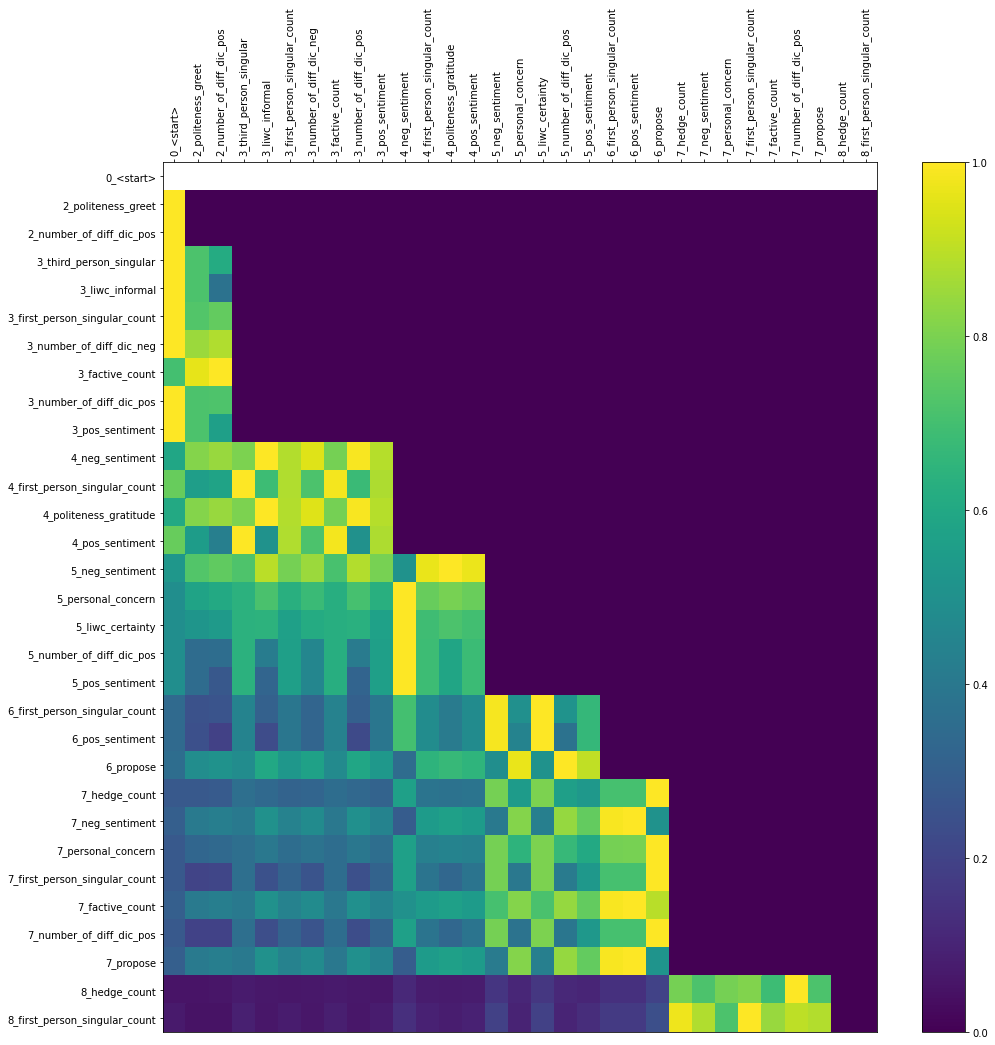

<start>
the benz still for sale ?
hi how are you ?
yes it is i took awesome care of it and it s in wonderful condition . i m asking <price>_1.0 for it .
i am good thank you . i came across your ad today regarding the benz . looks very clean and has nice low milage .
yes indeed low milage clean perfect interior and the paint job is flawless .
i love this car you have no idea but at the moment i m tuck on a budget of <price>_0.0 <price>_0.0 . will you be willing to accept an offer like this ?
no im sorry that half my asking price i would be willing to meet in the middle at <price>_0.4


In [215]:
# src = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
# trg = src
# scores = final_conv[0]['attn'][0][0]
#for cn in range(len(final_conv)):#chosen_ids
#for cn in [105, 107, 134, 228, 268]:
for cn in [5,14,26,27,29,33,34]:
####for cn in [27]:
#    turn_number = 6
#     flag = 1
# #     for x in range(turn_number + 1):
# #         if np.sum(final_conv[cn]['turn_list'][-1] == x) > 3:
# #             flag = 0
#     flag = 0
#     scores = copy.deepcopy(final_conv[cn]['cluster_maps'][-1])
#     for i in range(len(scores)):
#         check = 0
#         scores[i,i] = 0
#         scores[i,:] /= np.max(scores[i,:])
#         turns = set()
#         for j in range(i):
#             if scores[i,j] > 1e-1:
#                 check += 1
#                 turns.add(final_conv[cn]['turn_list'][-1][j])
#         if len(turns) > 3:
#             flag = 1
#             print ('check at ', i)
#             #pdb.set_trace()
#             turn_number = max(list(turns))
#             break
#     if flag == 0:
#         continue
    print(cn)
    conv_number = cn
    turn_number = min(8, final_conv[conv_number]['turn_list'][-1][-1])
#     plot_heatmap(final_conv[conv_number]['turn_list'][turn_number], 
#                  final_conv[conv_number]['strat_list'][turn_number], 
#                  final_conv[conv_number]['cluster_maps'][turn_number], 
#                  rowwise_norm = True,
#                  remove_diag = True)
    plot_heatmap(final_conv[conv_number]['turn_list'][turn_number], 
                 final_conv[conv_number]['strat_list'][turn_number], 
                 final_conv[conv_number]['gat_attn_maps'][turn_number], 
                 rowwise_norm = True,
                 remove_diag = True)
    #pdb.set_trace()
    #plt.clf()
    print ('\n'.join(final_conv[conv_number]['text'][:turn_number]))